In [ ]:
import pandas as pd
import numpy as np
import random
import os

pd.set_option('max_columns', None)
pd.set_option('max_rows', 2500)

# loading a couple of libraries for binning and plotting
from scipy.stats import binned_statistic_2d
from mplsoccer.pitch import Pitch, VerticalPitch

# for visualising the matrices
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import xGils.deltaxT as deltaxT

# libraries for high-dimensional clustering (sklean doesn't include hdbscan)
import hdbscan

# libraries for the PCA / clustering visualisation
from bokeh.plotting import figure, show, output_notebook, output_file, save
from bokeh.models import HoverTool, ColumnDataSource, value
from bokeh.io import export_png

# sklearn versions of t-SNE & PCA
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# loading seaborn in to use their colourblind palette
import seaborn

# importing pickle so we can pickle the xT matrices
import pickle

# **Team xT**

Starting very simply, we want to sum up the binned xT for each team per season. This will give us a vector that characterises the attacking threat of a team.

# **Delta xT**

Attacking threat can be measured **directly**: looking at the passes, crosses, dribbles, and shots of a team.

Defending always difficult to measure with **on-the-ball** events data because so much of the art of defending happens **off-the-ball**. Maldini quote: "If I have to make a tackle, I've already made a mistake."

So we use *delta xT* to indirectly probe at the ways in which opposing teams re-direct their threat at a given team, compared to how they play against all other teams, on average. This is *delta xT*.

## **Loading Opta Bayesian xT Data**

In [41]:
%%time

df_opta_xT = pd.read_csv('/Users/christian/Desktop/University/Birkbeck MSc Applied Statistics/Project/Data/Analysis Ready/Opta Bayesian xT/Bayesian_Opta_xT.csv')

# converting the timestamp string to a datetime
df_opta_xT['timeStamp'] = pd.to_datetime(df_opta_xT.timeStamp, format='%Y-%m-%d %H:%M:%S.%f')
df_opta_xT['kickOffDateTime'] = pd.to_datetime(df_opta_xT.kickOffDateTime, format='%Y-%m-%d %H:%M:%S.%f')

print (f'{len(df_opta_xT)} rows loaded.\n')

df_opta_xT.head()

3126182 rows loaded.

CPU times: user 13.1 s, sys: 1.56 s, total: 14.7 s
Wall time: 15 s


competition   season  seasonIndex  gameMonthIndex  matchId  \
0  English Premier League  2017/18            1           24212   918893   
1  English Premier League  2017/18            1           24212   918893   
2  English Premier League  2017/18            1           24212   918893   
3  English Premier League  2017/18            1           24212   918893   
4  English Premier League  2017/18            1           24212   918893   

   playerId           playerName    position     detailedPosition  \
0     59966  Alexandre Lacazette     Forward              Striker   
1    156074          Rob Holding    Defender             FullBack   
2     37605           Mesut Özil     Forward  AttackingMidfielder   
3    153256       Mohamed Elneny  Midfielder    CentralMidfielder   
4     98745      Héctor Bellerín  Midfielder      RightMidfielder   

   playerTeamId  minsPlayed  subIn  subOut  replacedReplacingPlayerId booking  \
0             3          95    NaN     NaN                        NaN     NaN   
1             3          67    NaN     1.0                        NaN     NaN   
2             3          95    NaN     NaN                        NaN     NaN   
3             3          66    NaN     1.0                        NaN     NaN   
4             3          95    NaN     NaN                        NaN     NaN   

  eventType eventSubType  eventTypeId    x1    y1    x2    y2 gameTime  \
0    attack         Pass            1  50.0  50.7  28.8  30.1      0:1   
1    attack         Pass            1  29.7  26.7  52.3  21.5      0:2   
2    attack         Pass            1  52.8  21.3  44.3  20.7      0:5   
3    attack         Pass            1  44.0  19.6  50.3   4.2      0:7   
4    attack         Pass            1  51.0   4.2  70.5   5.0      0:9   

                timeStamp  periodId homeTeamName  homeTeamId    awayTeamName  \
0 2017-08-11 19:46:04.968         1      Arsenal           3  Leicester City   
1 2017-08-11 19:46:05.554         1      Arsenal           3  Leicester City   
2 2017-08-11 19:46:08.554         1      Arsenal           3  Leicester City   
3 2017-08-11 19:46:10.554         1      Arsenal           3  Leicester City   
4 2017-08-11 19:46:13.519         1      Arsenal           3  Leicester City   

   awayTeamId     kickOffDateTime  minute  second    x1_m    y1_m    x2_m  \
0          13 2017-08-11 19:45:00       0       1  52.500  34.476  30.240   
1          13 2017-08-11 19:45:00       0       2  31.185  18.156  54.915   
2          13 2017-08-11 19:45:00       0       5  55.440  14.484  46.515   
3          13 2017-08-11 19:45:00       0       7  46.200  13.328  52.815   
4          13 2017-08-11 19:45:00       0       9  53.550   2.856  74.025   

     y2_m        xT  
0  20.468 -0.003278  
1  14.620  0.003008  
2  14.076 -0.001186  
3   2.856 -0.000542  
4   3.400  0.005850

In [42]:
# pass events (inc. crosses)
opta_successful_pass_events = ['2nd Assist','Assist','Chance Created','Cross','Pass']
opta_failed_pass_events = ['Failed Pass','Offside Pass']

# dribble events
opta_successful_dribble_events = ['Dribble']
opta_failed_dribble_events = ['Failed Dribble']

# shot events
opta_successful_shot_events = ['Goal']
opta_failed_shot_events = ['Hit Woodwork','Miss','Missed Penalty','Penalty Saved','Shot Blocked','Shot Saved']

opta_events_successful = opta_successful_pass_events + opta_successful_dribble_events + opta_successful_shot_events
opta_events_relevant = opta_successful_pass_events + opta_failed_pass_events + opta_successful_dribble_events + opta_failed_dribble_events + opta_successful_shot_events + opta_failed_shot_events

opta_events_relevant

['2nd Assist',
 'Assist',
 'Chance Created',
 'Cross',
 'Pass',
 'Failed Pass',
 'Offside Pass',
 'Dribble',
 'Failed Dribble',
 'Goal',
 'Hit Woodwork',
 'Miss',
 'Missed Penalty',
 'Penalty Saved',
 'Shot Blocked',
 'Shot Saved']

---

## **Team xT**

In [43]:
# things we want data for
competition = 'English Premier League'
seasons = ['2017/18','2018/19','2019/20','2020/21']

# just interested in the EPL for this analysis, for the seasons specified above
df_xT = df_opta_xT.loc[(df_opta_xT['competition'] == competition) & (df_opta_xT['season'].isin(seasons))].copy().reset_index(drop=True)

# producing a dataframe for team ref
df_epl_teams = deltaxT.produce_df_teams_ref(df_xT)
df_epl_teams

teamName  teamId
0          Manchester United       1
1               Leeds United       2
2                    Arsenal       3
3           Newcastle United       4
4          Tottenham Hotspur       6
5                Aston Villa       7
6                    Chelsea       8
7                    Everton      11
8             Leicester City      13
9                  Liverpool      14
10               Southampton      20
11           West Ham United      21
12            Crystal Palace      31
13      West Bromwich Albion      35
14  Brighton and Hove Albion      36
15         Huddersfield Town      38
16   Wolverhampton Wanderers      39
17           Manchester City      43
18              Norwich City      45
19          Sheffield United      49
20                    Fulham      54
21                   Watford      57
22              Swansea City      80
23                   Burnley      90
24               Bournemouth      91
25              Cardiff City      97
26                Stoke City     110

### **Exploratory Code**

#### Looking at most common coords

In [44]:
df_opta_xT.groupby(['x1_m','y1_m'])\
        .agg({'playerId':'count'})\
        .reset_index()\
        .rename(columns={'playerId':'freq'})\
        .sort_values('freq', ascending=False)\
        .head(10)

x1_m    y1_m  freq
748790  104.475  67.660  7801
0         0.000   0.000  7680
748731  104.475   0.340  7615
395097   52.500  34.000   839
394720   52.395  34.000   512
21163     5.250  25.160   510
21390     5.250  42.840   501
395476   52.605  34.000   496
395475   52.605  33.932   468
394719   52.395  33.932   468

#### Aggregating xT Per Team Per Season

In [45]:
df_xT.groupby(['season','playerTeamId']).agg({'x1_m':'count'}).reset_index()\
    .rename(columns={'x1_m':'numEvents'})\
    .sort_values(['playerTeamId','season'], ascending=[True,True])\
    .head()

season  playerTeamId  numEvents
0   2017/18             1      36001
20  2018/19             1      34841
40  2019/20             1      35473
60  2020/21             1      35528
61  2020/21             2      34558

### **Initial Look at Team xT**

**Purely grouping and summing per EPL team per season**

> TODO: Could definitely put 10 teams in a bumpy chart

In [46]:
df_team_xT_total = df_xT.groupby(['competition','season','playerTeamId'])\
                    .agg({'xT':np.sum})\
                    .reset_index()\
                    .merge(df_epl_teams, left_on=['playerTeamId'], right_on=['teamId'])\
                    .drop(columns=['playerTeamId'])\
                    [['season','teamName','teamId','xT']]

df_team_xT_total

season                  teamName  teamId         xT
0   2017/18         Manchester United       1  35.969278
1   2018/19         Manchester United       1  37.888261
2   2019/20         Manchester United       1  29.991356
3   2020/21         Manchester United       1  34.404555
4   2017/18                   Arsenal       3  42.259737
5   2018/19                   Arsenal       3  37.127155
6   2019/20                   Arsenal       3  26.558598
7   2020/21                   Arsenal       3  28.341500
8   2017/18          Newcastle United       4  28.894425
9   2018/19          Newcastle United       4  28.869258
10  2019/20          Newcastle United       4  23.117532
11  2020/21          Newcastle United       4  26.193093
12  2017/18         Tottenham Hotspur       6  39.186948
13  2018/19         Tottenham Hotspur       6  36.119745
14  2019/20         Tottenham Hotspur       6  23.026354
15  2020/21         Tottenham Hotspur       6  24.587658
16  2017/18                   Chelsea       8  36.404324
17  2018/19                   Chelsea       8  36.391237
18  2019/20                   Chelsea       8  38.716210
19  2020/21                   Chelsea       8  34.252039
20  2017/18                   Everton      11  30.507513
21  2018/19                   Everton      11  36.997694
22  2019/20                   Everton      11  36.049457
23  2020/21                   Everton      11  29.578741
24  2017/18            Leicester City      13  29.723875
25  2018/19            Leicester City      13  33.785467
26  2019/20            Leicester City      13  33.007391
27  2020/21            Leicester City      13  25.175196
28  2017/18                 Liverpool      14  44.413529
29  2018/19                 Liverpool      14  47.294194
30  2019/20                 Liverpool      14  41.814434
31  2020/21                 Liverpool      14  38.552561
32  2017/18               Southampton      20  33.003049
33  2018/19               Southampton      20  33.257768
34  2019/20               Southampton      20  31.140397
35  2020/21               Southampton      20  22.504257
36  2017/18           West Ham United      21  26.719005
37  2018/19           West Ham United      21  32.402573
38  2019/20           West Ham United      21  34.911016
39  2020/21           West Ham United      21  32.152112
40  2017/18            Crystal Palace      31  31.527684
41  2018/19            Crystal Palace      31  31.693980
42  2019/20            Crystal Palace      31  28.552143
43  2020/21            Crystal Palace      31  25.700311
44  2017/18      West Bromwich Albion      35  34.178619
45  2020/21      West Bromwich Albion      35  25.506787
46  2017/18  Brighton and Hove Albion      36  26.280880
47  2018/19  Brighton and Hove Albion      36  33.403230
48  2019/20  Brighton and Hove Albion      36  29.804080
49  2020/21  Brighton and Hove Albion      36  33.320073
50  2017/18         Huddersfield Town      38  19.873444
51  2018/19         Huddersfield Town      38  28.306781
52  2017/18           Manchester City      43  42.711687
53  2018/19           Manchester City      43  46.901252
54  2019/20           Manchester City      43  49.962148
55  2020/21           Manchester City      43  29.939337
56  2017/18                   Watford      57  32.730451
57  2018/19                   Watford      57  31.709644
58  2019/20                   Watford      57  30.575707
59  2017/18              Swansea City      80  18.246903
60  2017/18                   Burnley      90  32.098119
61  2018/19                   Burnley      90  36.603108
62  2019/20                   Burnley      90  34.355730
63  2020/21                   Burnley      90  30.999896
64  2017/18               Bournemouth      91  30.842739
65  2018/19               Bournemouth      91  36.910950
66  2019/20               Bournemouth      91  29.894454
67  2017/18                Stoke City     110  27.832308
68  2018/19   Wolverhampton Wanderers      39  30.510783
69  2019/20   W

### **Function to sum xT into bins per team**

> What should this function look like?

> Probably should be nice and clean, producing a team's xT vector for that seasondf_xT.playerTeamId.drop_duplicates().values

### **Plotting xT for a Particular Team for a Particular Season**

#### Manchester United 2020/21

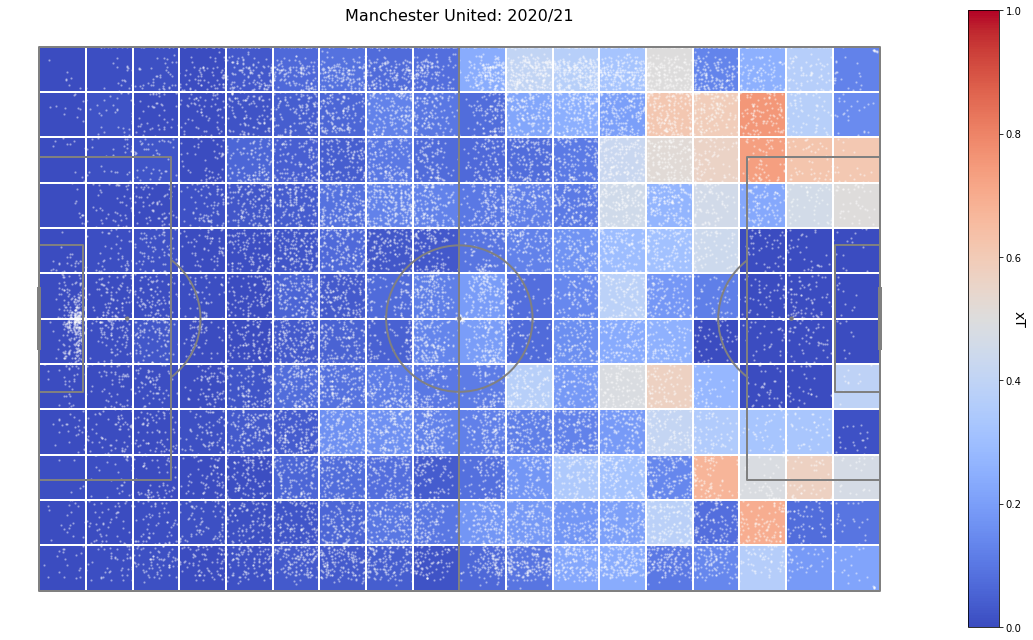

In [47]:
df_plot = df_xT.loc[(df_xT['playerTeamId'] == 1) & (df_xT['season'] == '2020/21')].reset_index(drop=True).copy()
filepath = '/Users/christian/Desktop/University/Birkbeck MSc Applied Statistics/Project/Plots/Team xT/MUFC_2020_21.png'
deltaxT.plot_xT_pitch(df_plot, opta_events_relevant, filepath, transparent=False, teamOrPlayer='team', bins=(18,12), fontsize=16, cmap=cm.coolwarm, vmax_override=1.0)

#### Chelsea 2020/21

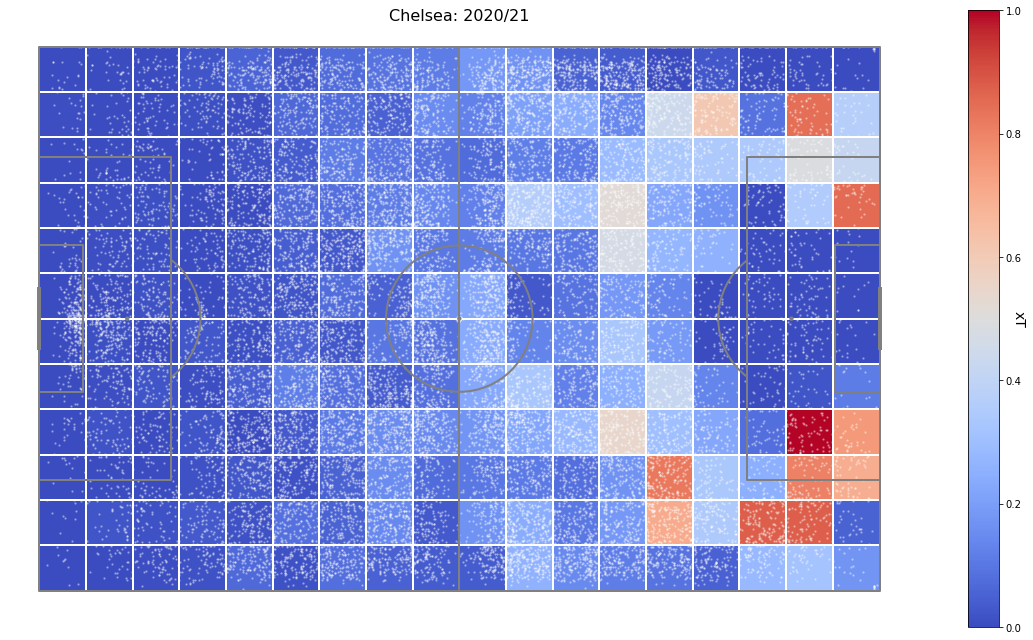

In [48]:
df_plot = df_xT.loc[(df_xT['playerTeamId'] == 8) & (df_xT['season'] == '2020/21')].reset_index(drop=True).copy()
filepath = '/Users/christian/Desktop/University/Birkbeck MSc Applied Statistics/Project/Plots/Team xT/Chelsea_2020_21.png'
deltaxT.plot_xT_pitch(df_plot, opta_events_relevant, filepath, transparent=False, teamOrPlayer='team', bins=(18,12), fontsize=16, cmap=cm.coolwarm, vmax_override=1.0)

#### Liverpool 2020/21

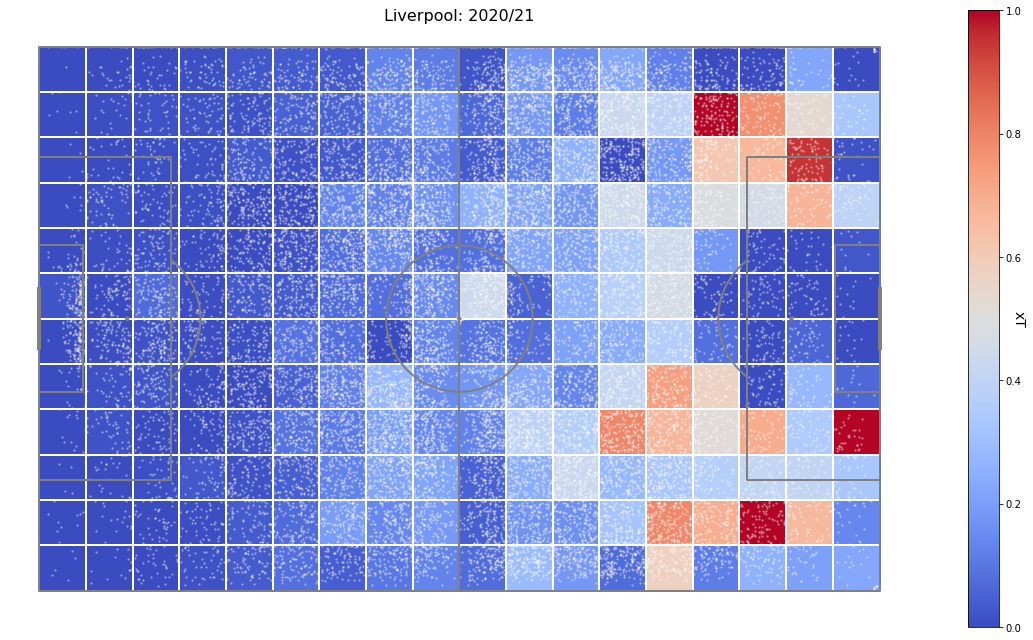

In [49]:
df_plot = df_xT.loc[(df_xT['playerTeamId'] == 14) & (df_xT['season'] == '2020/21')].reset_index(drop=True).copy()
filepath = '/Users/christian/Desktop/University/Birkbeck MSc Applied Statistics/Project/Plots/Team xT/Liverpool_2020_21.png'
deltaxT.plot_xT_pitch(df_plot, opta_events_relevant, filepath, transparent=False, teamOrPlayer='team', bins=(18,12), fontsize=16, cmap=cm.coolwarm, vmax_override=1.0)

#### Arsenal 2020/21

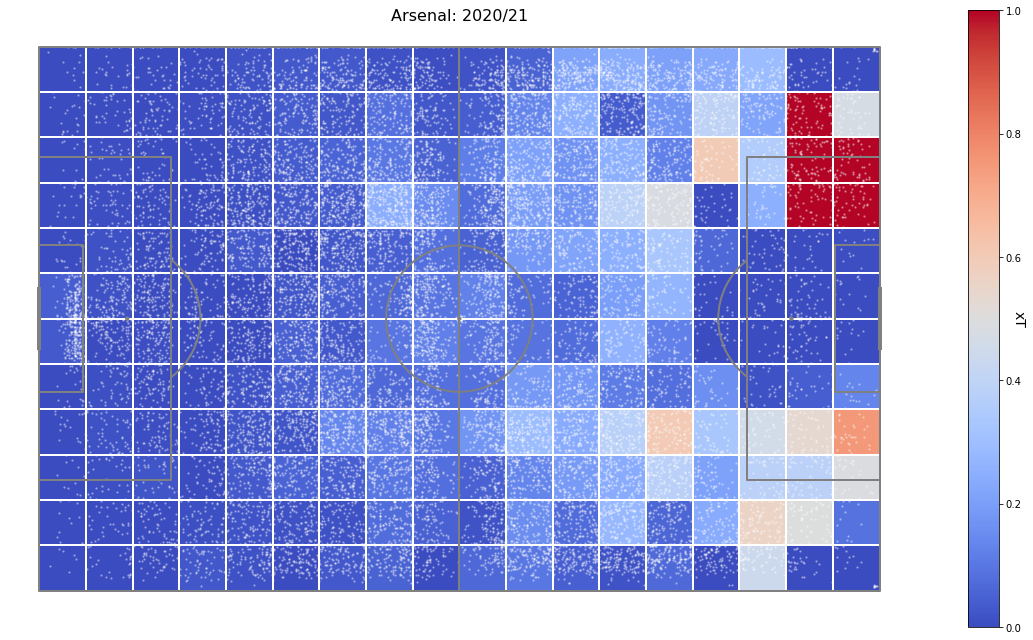

In [50]:
df_plot = df_xT.loc[(df_xT['playerTeamId'] == 3) & (df_xT['season'] == '2020/21')].reset_index(drop=True).copy()
filepath = '/Users/christian/Desktop/University/Birkbeck MSc Applied Statistics/Project/Plots/Team xT/Arsenal_2020_21.png'
deltaxT.plot_xT_pitch(df_plot, opta_events_relevant, filepath, transparent=False, teamOrPlayer='team', bins=(18,12), fontsize=16, cmap=cm.coolwarm, vmax_override=1.0)

#### Manchester City 2020/21

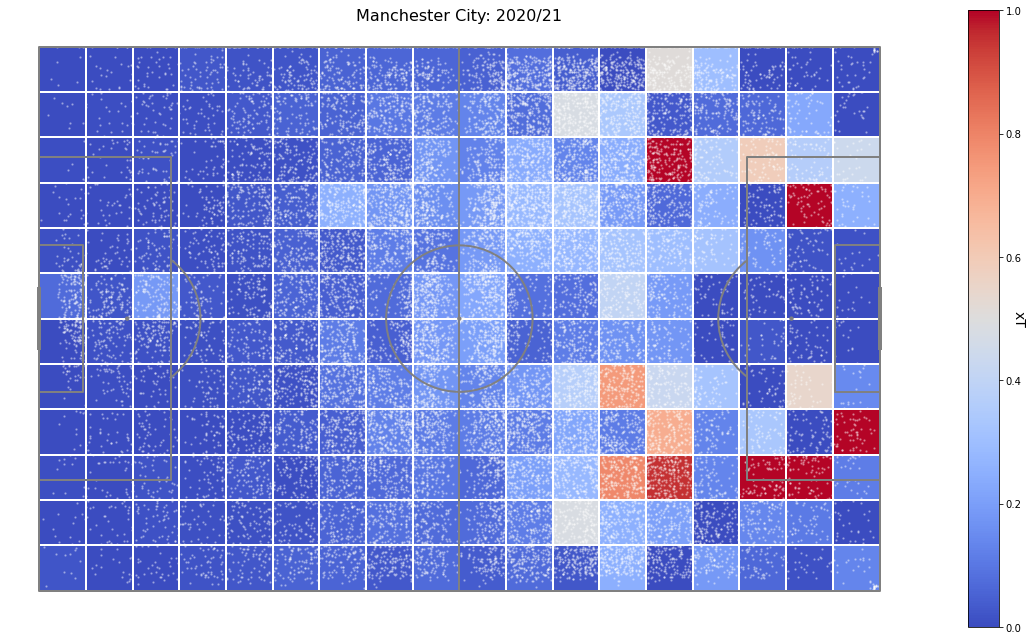

In [51]:
df_plot = df_xT.loc[(df_xT['playerTeamId'] == 43) & (df_xT['season'] == '2020/21')].reset_index(drop=True).copy()
filepath = '/Users/christian/Desktop/University/Birkbeck MSc Applied Statistics/Project/Plots/Team xT/City_2020_21.png'
deltaxT.plot_xT_pitch(df_plot, opta_events_relevant, filepath, transparent=False, teamOrPlayer='team', bins=(18,12), fontsize=16, cmap=cm.coolwarm, vmax_override=1.0)

### **Plotting xT for a Range of Seasons for a Range of Teams**

CPU times: user 32.7 s, sys: 3.72 s, total: 36.5 s
Wall time: 34.9 s


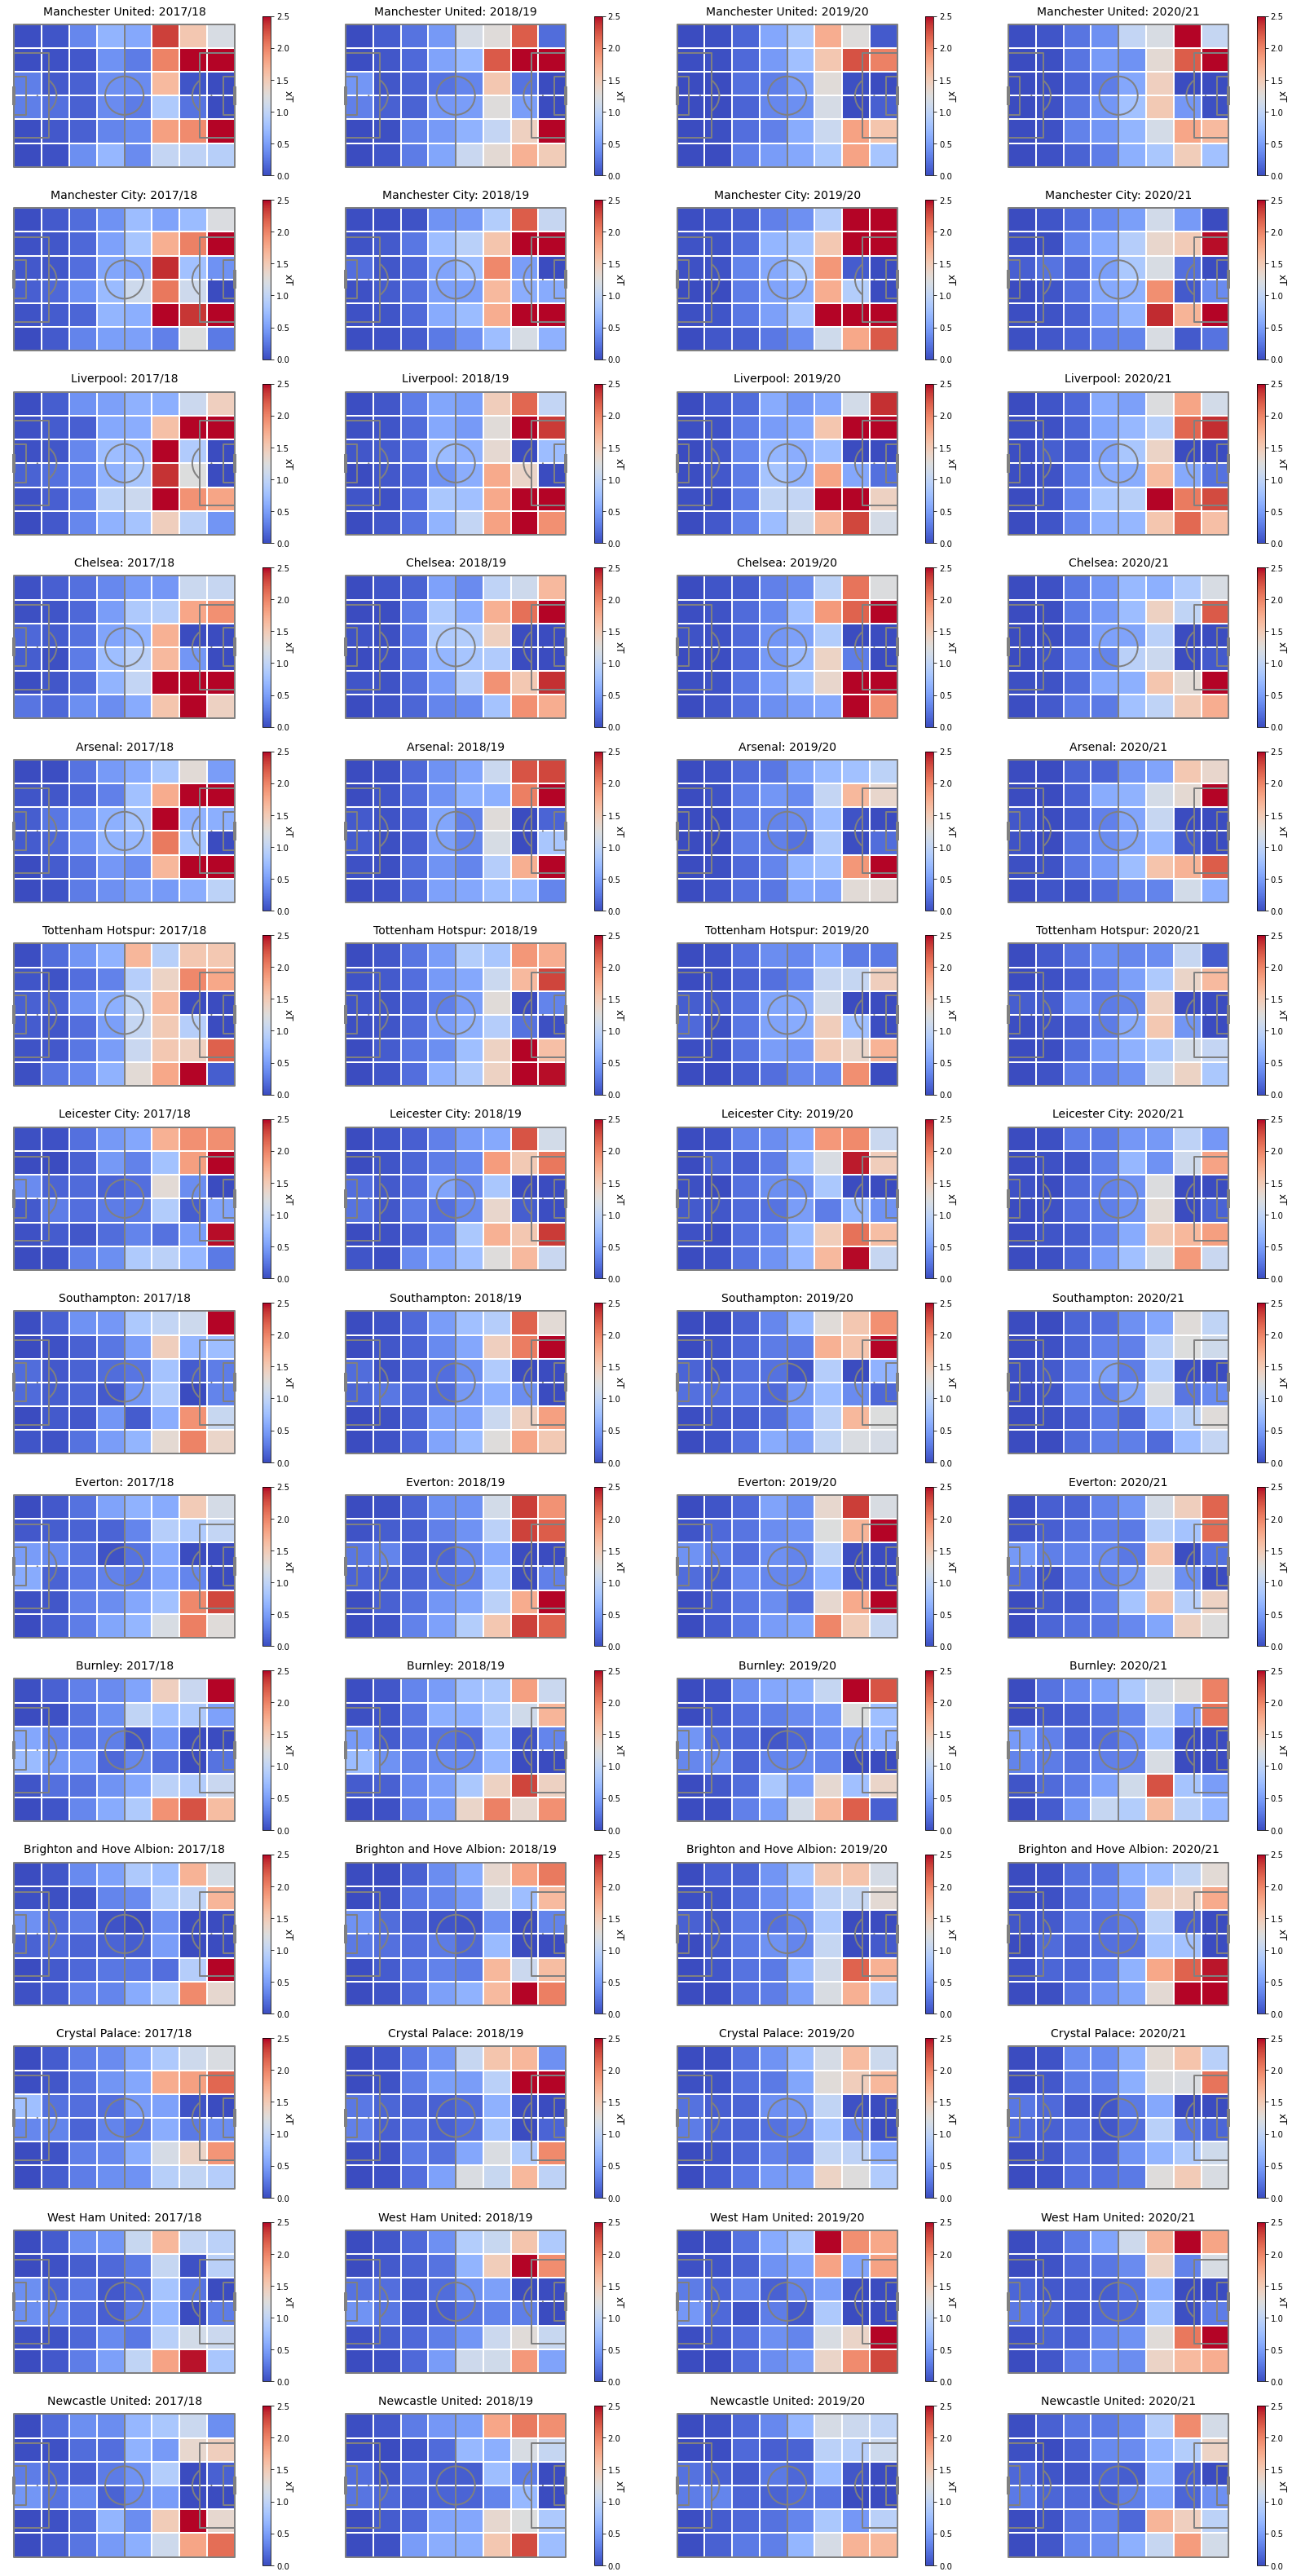

In [13]:
%%time

lst_teams = [1,43,14,8,3,6,13,20,11,90,36,31,21,4]
seasons = ['2017/18','2018/19','2019/20','2020/21']
cols = ['Reds','Blues','Reds','Blues','Reds','Blues']

filepath = '/Users/christian/Desktop/University/Birkbeck MSc Applied Statistics/Project/Plots/Team xT/MajorClubs.png'

deltaxT.plot_xT_multi_pitch(df_xT, opta_events_relevant, lst_teams, seasons, [cm.coolwarm]*len(lst_teams), filepath, transparent=False, teamOrPlayer='team', eventCol='eventSubType', bins=(8,6), figsize=(24,44), fontsize=14, vmax_override=2.5, scatter=0)

---

## **Delta xT**

> This is the key bit

> Want to get a nice function to calculate the Delta xT statistics, and then a complementary plotting function (almost exactly like the above).

> Will probably have a few mini helper functions for the matches.

### Testing Delta xT with Man U: teamId = 1, season: 2020/21

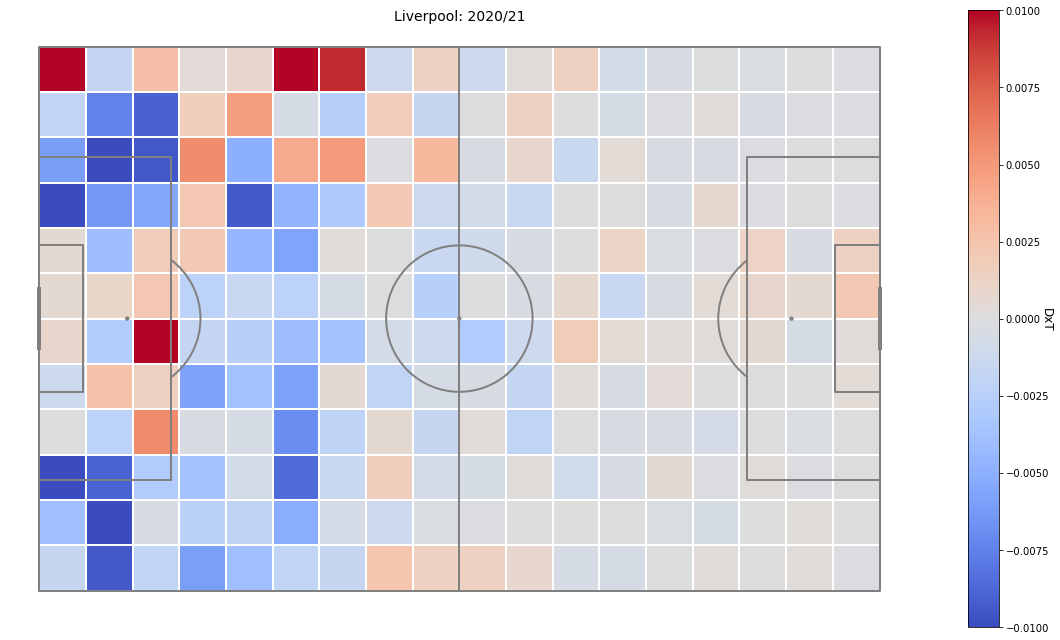

In [52]:
df_teams = deltaxT.produce_df_teams_ref(df_xT)

teamId = 14
teamName = df_teams.loc[df_teams['teamId'] == teamId, 'teamName'].values[0]
season = '2020/21'

df_season = df_xT.loc[df_xT['season'] == season].reset_index(drop=True).copy()
delta_xT_repo = '/Users/christian/Desktop/University/Birkbeck MSc Applied Statistics/Project/Plots/Team Delta xT'

deltaxT.plot_delta_xT_pitch(df_season, teamId, opta_events_relevant, os.path.join(delta_xT_repo, f'{teamName} {season}.png'.replace('/','-')), transparent=False, eventCol='eventSubType', bins=(18,12), exclCorners = 1, figsize=(16,9), fontsize=14, symmetricDeltaVizOverride=1)


### **Plotting Delta xT for a Range of Seasons for a Range of Teams**

CPU times: user 8min 7s, sys: 14.8 s, total: 8min 22s
Wall time: 7min 17s


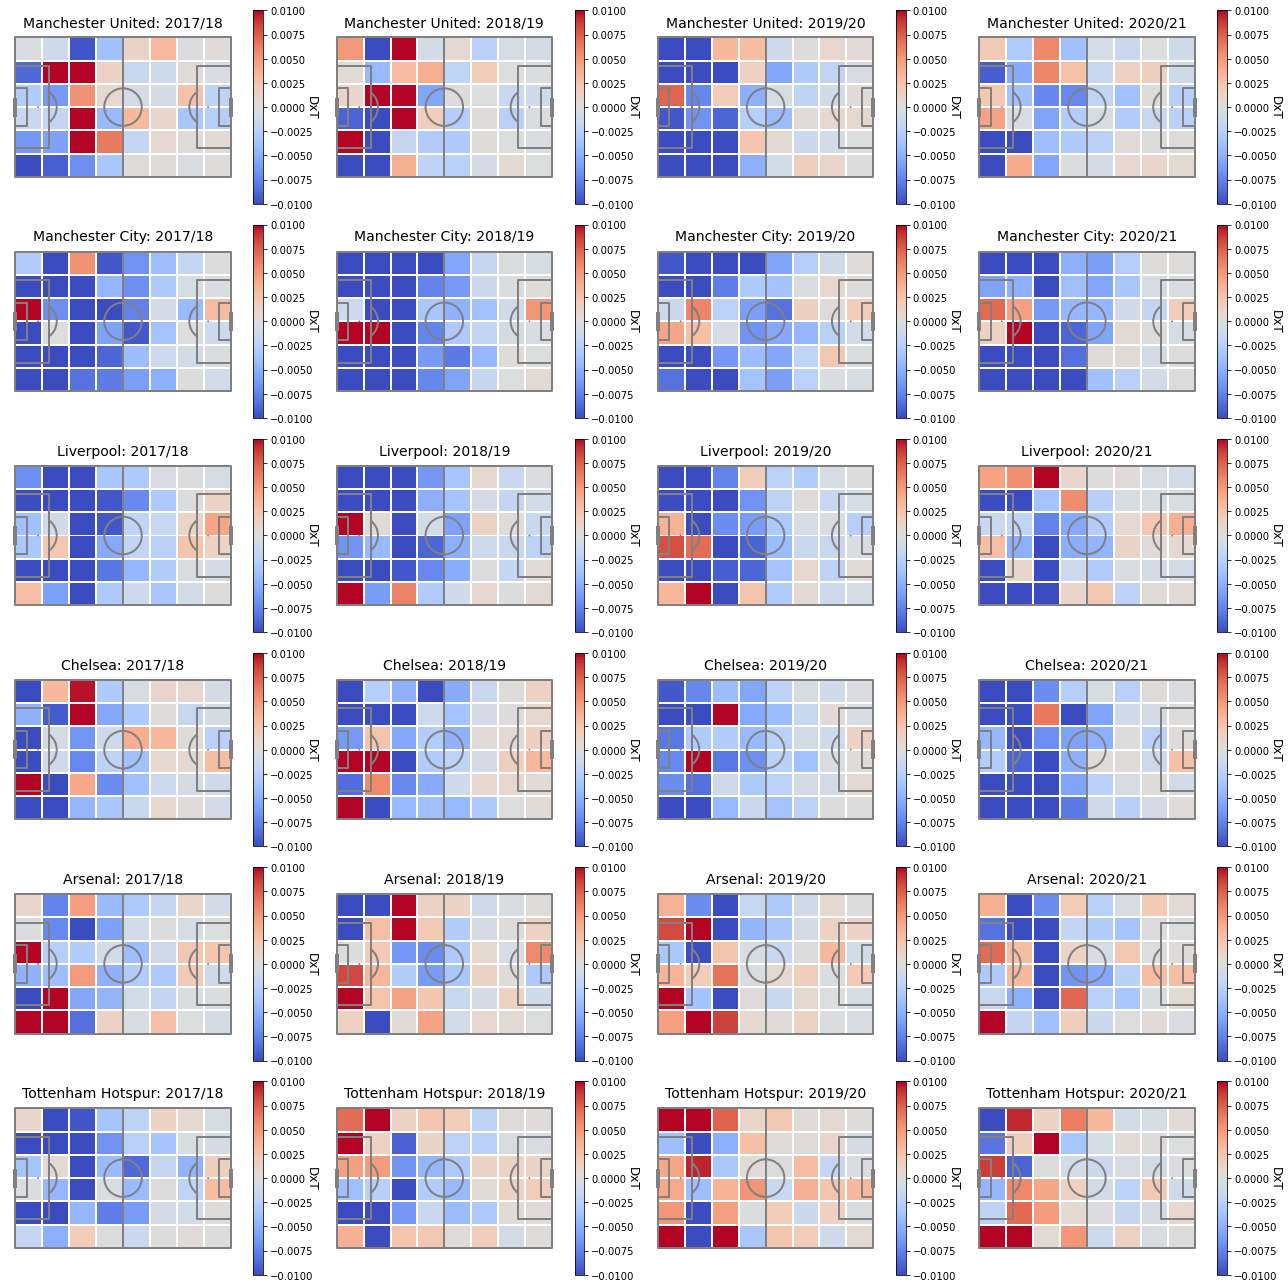

In [15]:
%%time

lst_teams = [1,43,14,8,3,6]#,13,20,11,90,36,31,21,4]
seasons = ['2017/18','2018/19','2019/20','2020/21']
cols = ['Reds','Blues','Reds','Blues','Reds','Blues']

filepath = '/Users/christian/Desktop/University/Birkbeck MSc Applied Statistics/Project/Plots/Team Delta xT/BigSixDeltaxT.png'

deltaxT.plot_delta_xT_multi_pitch(df_xT, opta_events_relevant, lst_teams, seasons, [cm.coolwarm]*len(lst_teams), filepath, transparent=False, eventCol='eventSubType', bins=(8,6), exclCorners=1, figsize=(18,18), fontsize=14, symmetricDeltaVizOverride=1)

CPU times: user 18min 42s, sys: 33.6 s, total: 19min 16s
Wall time: 16min 43s


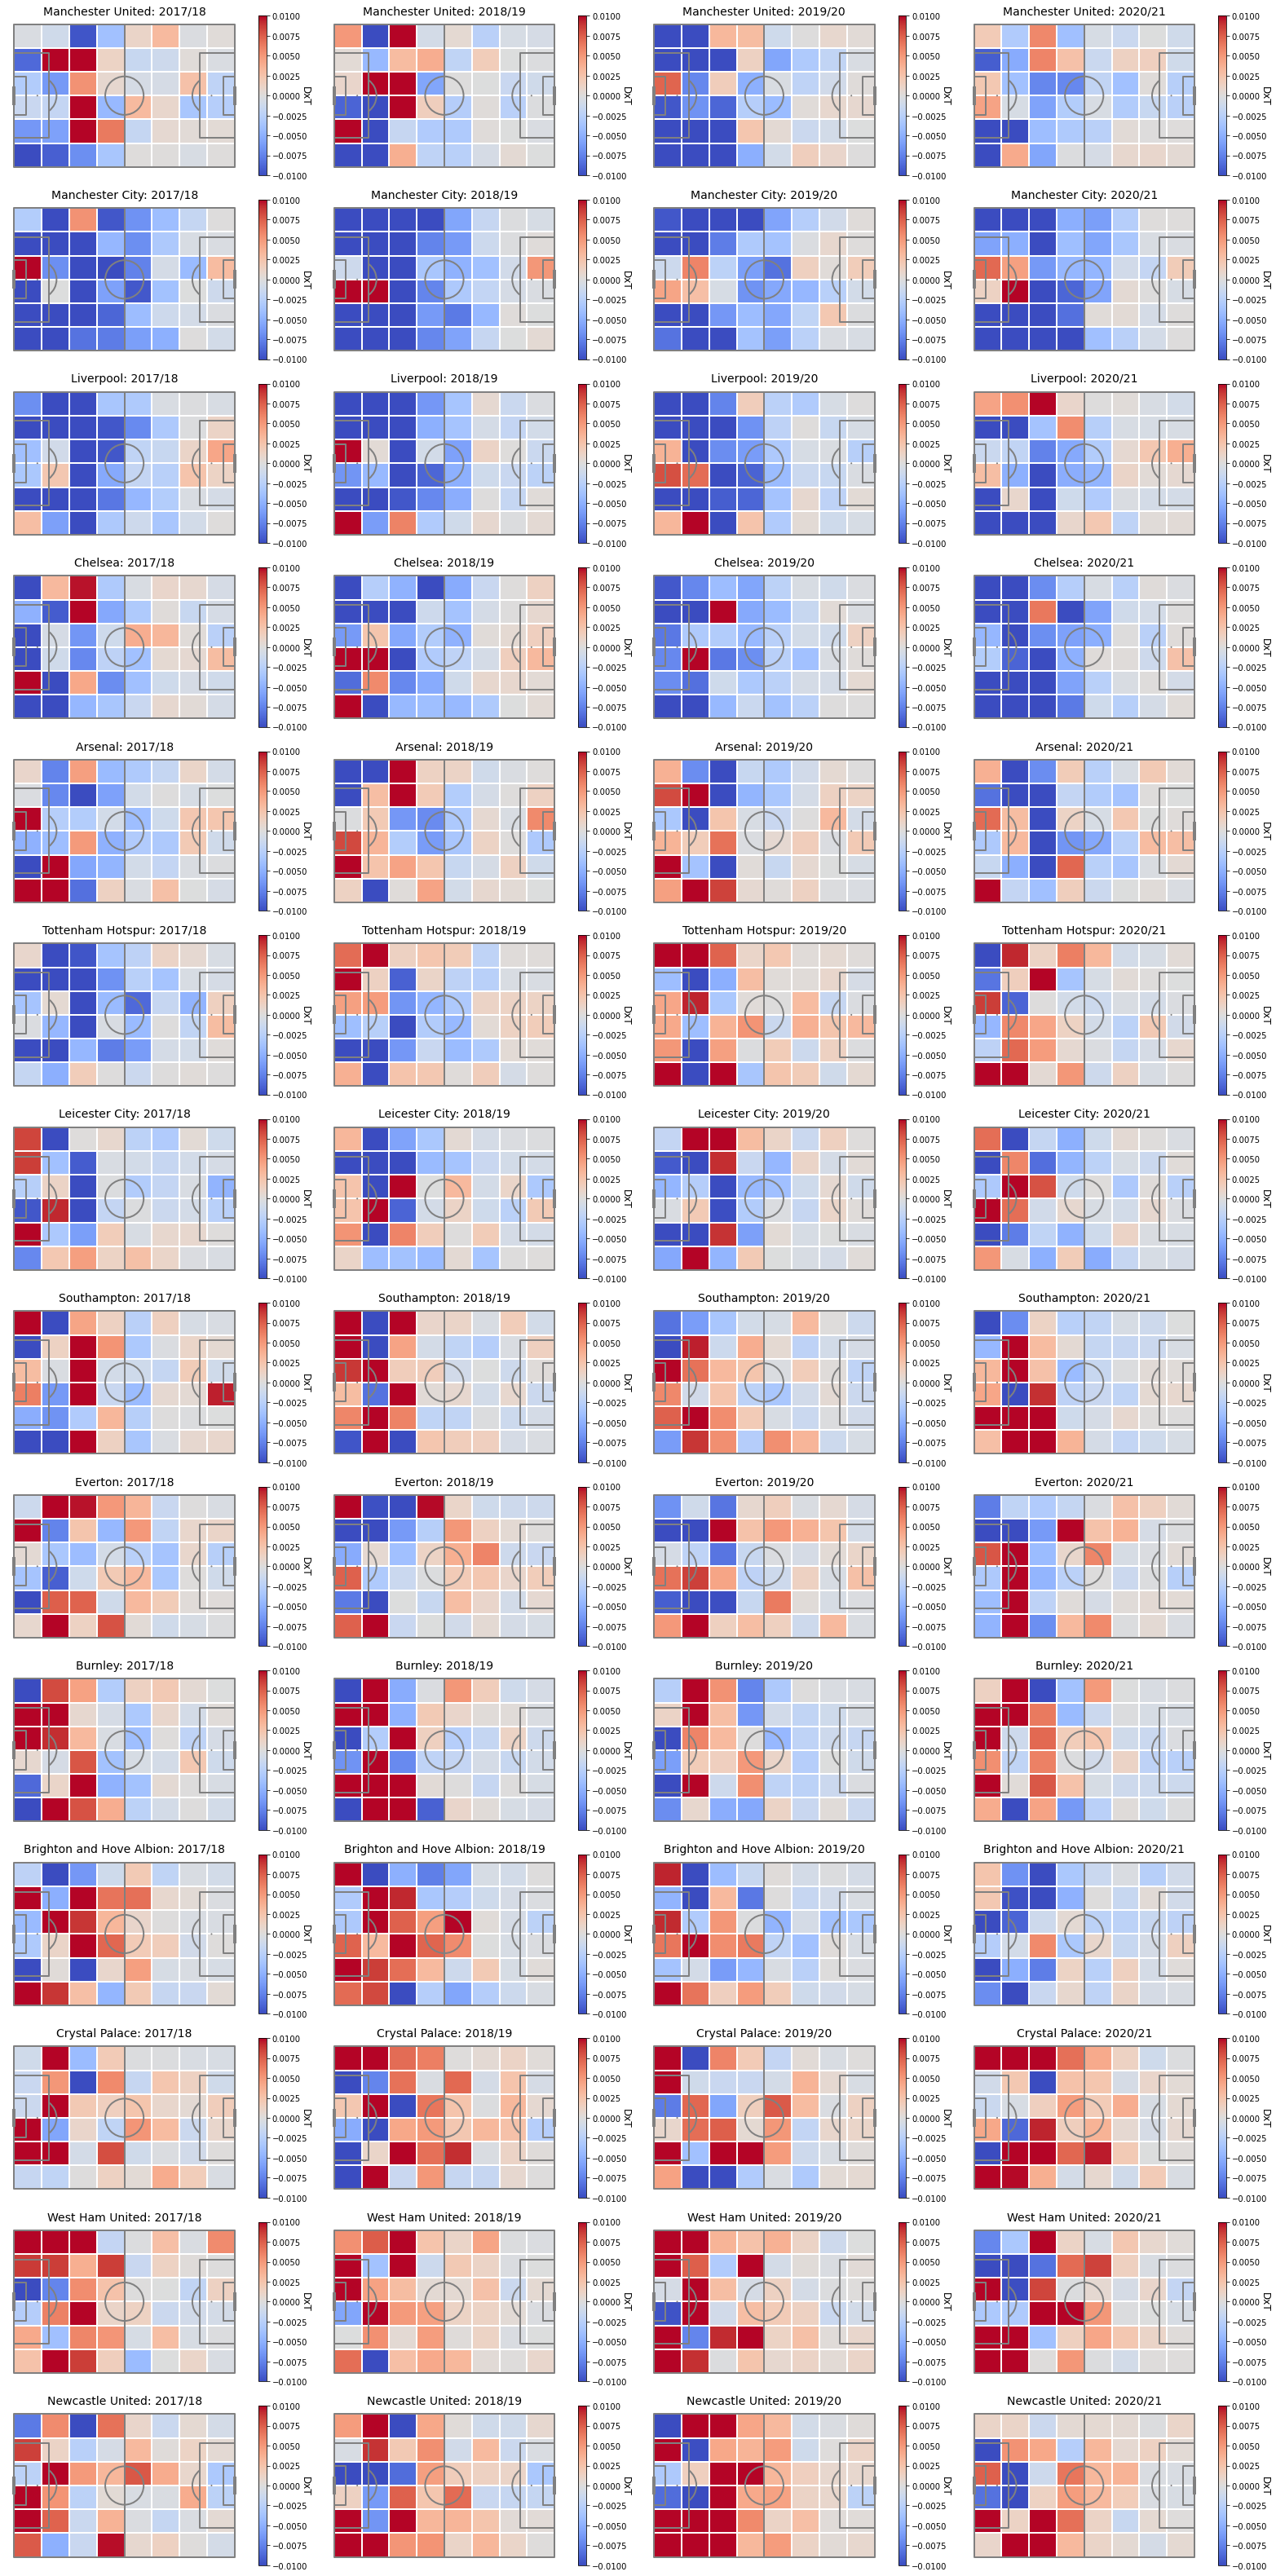

In [16]:
%%time

lst_teams = [1,43,14,8,3,6,13,20,11,90,36,31,21,4]
seasons = ['2017/18','2018/19','2019/20','2020/21']

filepath = '/Users/christian/Desktop/University/Birkbeck MSc Applied Statistics/Project/Plots/Team Delta xT/MajorClubsDeltaxT.png'

deltaxT.plot_delta_xT_multi_pitch(df_xT, opta_events_relevant, lst_teams, seasons, [cm.coolwarm]*len(lst_teams), filepath, transparent=False, eventCol='eventSubType', bins=(8,6), exclCorners=1, figsize=(22,44), fontsize=14, symmetricDeltaVizOverride=1)

---

## **Integrating Wyscout**

### **Okay so how easy is this to get working with Wyscout?**

Which fields do I need?

* xT
* x1_m
* y1_m
* homeTeamId
* awayTeamId
* matchId
* **playerTeamId** (same as Wyscout's **teamId**)

And also need to have **events** that are under the  **eventSubType** column.

In [53]:
%%time

# loading in our pre-modelled Wyscout data in Uefa format [x1_m, y1_m, x2_m, y2_m]
df_wyscout = pd.read_csv('/Users/christian/Desktop/University/Birkbeck MSc Applied Statistics/Project/Data/Analysis Ready/Wyscout xT/Wyscout_Domestic_Comps_xT_Opta_Surface.csv')

# duplicating teamId column in Wyscout to playerTeamId column in Opta
df_wyscout['playerTeamId'] = df_wyscout['teamId']

# adding in the season name for symmetry with the opta data
df_wyscout['season'] = '2017/18'

# masking playerName
df_wyscout['playerName'] = ''

# will need team names for labels
df_wyscout_teams = pd.read_csv('/Users/christian/Desktop/University/Birkbeck MSc Applied Statistics/Project/Data/Analysis Ready/Wyscout Reference/df_teams.csv')
# only interested in domestic clubs rather than nations
df_wyscout_teams = df_wyscout_teams.loc[df_wyscout_teams['teamType'] == 'club', ['teamId','teamName','teamArea']].reset_index(drop=True).copy()

# getting homeTeamName and awayTeamName in the Wyscout data just to make life easier
df_wyscout = df_wyscout.merge(df_wyscout_teams, left_on='homeTeamId',  right_on='teamId', suffixes=('','_home')).rename(columns={'teamName':'homeTeamName'}).drop(columns=['teamId_home','teamArea'])
df_wyscout = df_wyscout.merge(df_wyscout_teams, left_on='awayTeamId',  right_on='teamId', suffixes=('','_away')).rename(columns={'teamName':'awayTeamName'}).drop(columns=['teamId_away','teamArea'])

# pass events (inc. crosses)
wyscout_successful_pass_events = ['Successful Pass']
wyscout_failed_pass_events = ['Failed Pass']

# dribble events
wyscout_successful_dribble_events = ['Successful Dribble', 'Successful Take-On']
wyscout_failed_dribble_events = ['Failed Dribble','Failed Take-On']

# shot events
wyscout_successful_shot_events = ['Goal']
wyscout_failed_shot_events = ['Failed Shot']

wyscout_events_relevant = wyscout_successful_dribble_events + wyscout_successful_pass_events + wyscout_successful_shot_events + wyscout_failed_dribble_events + wyscout_failed_pass_events + wyscout_failed_shot_events

wyscout_events_relevant

CPU times: user 20 s, sys: 7.1 s, total: 27.1 s
Wall time: 28.1 s


['Successful Dribble',
 'Successful Take-On',
 'Successful Pass',
 'Goal',
 'Failed Dribble',
 'Failed Take-On',
 'Failed Pass',
 'Failed Shot']

In [54]:
df_wyscout.columns

Index(['source', 'matchId', 'matchPeriod', 'eventSec', 'possessionTimeSec',
       'playerPossessionTimeSec', 'matchEventIndex', 'teamId', 'homeTeamId',
       'homeScore', 'awayTeamId', 'awayScore', 'homeFlag', 'id', 'eventName',
       'subEventName', 'previousSubEventName', 'possessionTeamId',
       'possessionSequenceIndex', 'playerId', 'shortName', 'roleCode',
       'strongFlag', 'weakFlag', 'goalDelta', 'numReds', 'start_x', 'start_y',
       'end_x', 'end_y', 'tags', 'successFlag', 'goalScoredFlag', 'takeOnFlag',
       'dribbleFlag', 'dribbleSuccessFlag', 'eventSubType', 'x1_m', 'y1_m',
       'x2_m', 'y2_m', 'xT', 'playerTeamId', 'season', 'playerName',
       'homeTeamName', 'awayTeamName'],
      dtype='object')

In [55]:
df_wyscout_teams.loc[df_wyscout_teams.teamName.str.contains('Manchester')].head()

teamId           teamName teamArea
67    1625    Manchester City  England
79    1611  Manchester United  England

---

## **Getting `xT_grid` and `delta_xT_grid` working with Wyscout**

## **Comparing Wyscout & Opta Plots**

### **Plotting xT for a Particular Team for a Particular Season**

#### Manchester United 2017/18

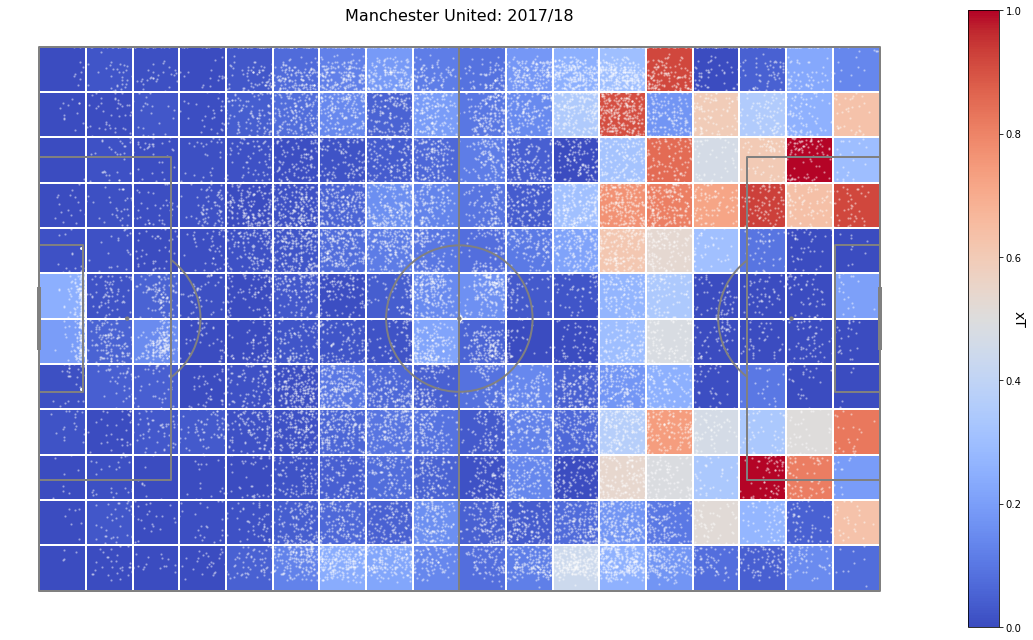

In [56]:
df_plot = df_xT.loc[(df_xT['playerTeamId'] == 1) & (df_xT['season'] == '2017/18')].reset_index(drop=True).copy()
filepath = '/Users/christian/Desktop/University/Birkbeck MSc Applied Statistics/Project/Plots/Team xT/Opta_MUFC_1718.png'
deltaxT.plot_xT_pitch(df_plot, opta_events_relevant, filepath, transparent=False, teamOrPlayer='team', bins=(18,12), fontsize=16, cmap=cm.coolwarm, vmax_override=1.0)

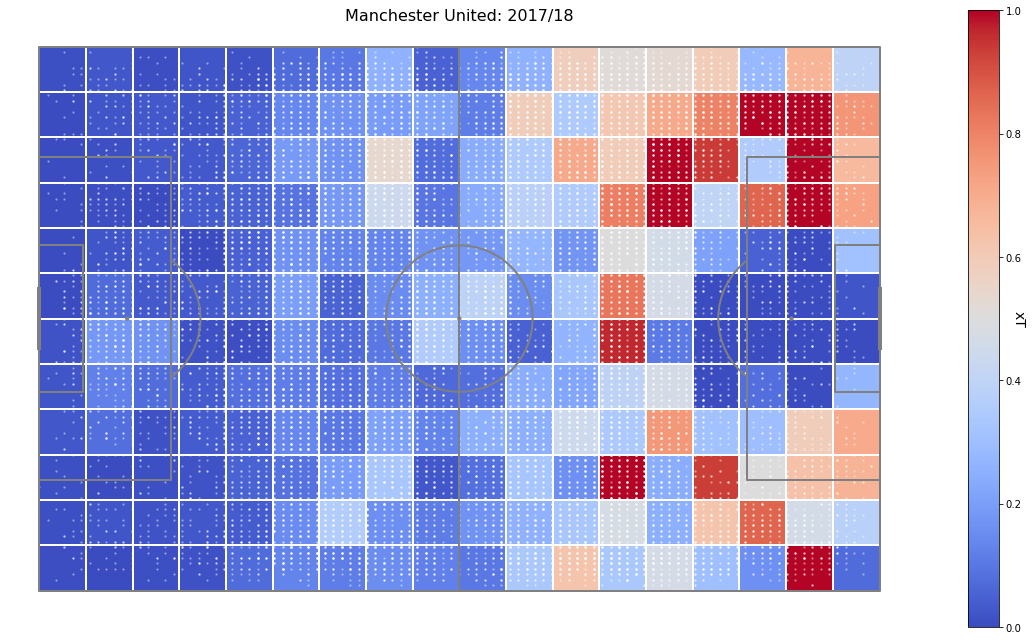

In [57]:
filepath = '/Users/christian/Desktop/University/Birkbeck MSc Applied Statistics/Project/Plots/Team xT/Wyscout_MUFC_1718.png'
deltaxT.plot_xT_pitch(df_wyscout.loc[df_wyscout['teamId'] == 1611], wyscout_events_relevant, filepath, transparent=False, teamOrPlayer='team', bins=(18,12), fontsize=16, cmap=cm.coolwarm, vmax_override=1.0)

### **Plotting Delta xT for a Particular Team for a Particular Season**

#### Manchester United 2017/18

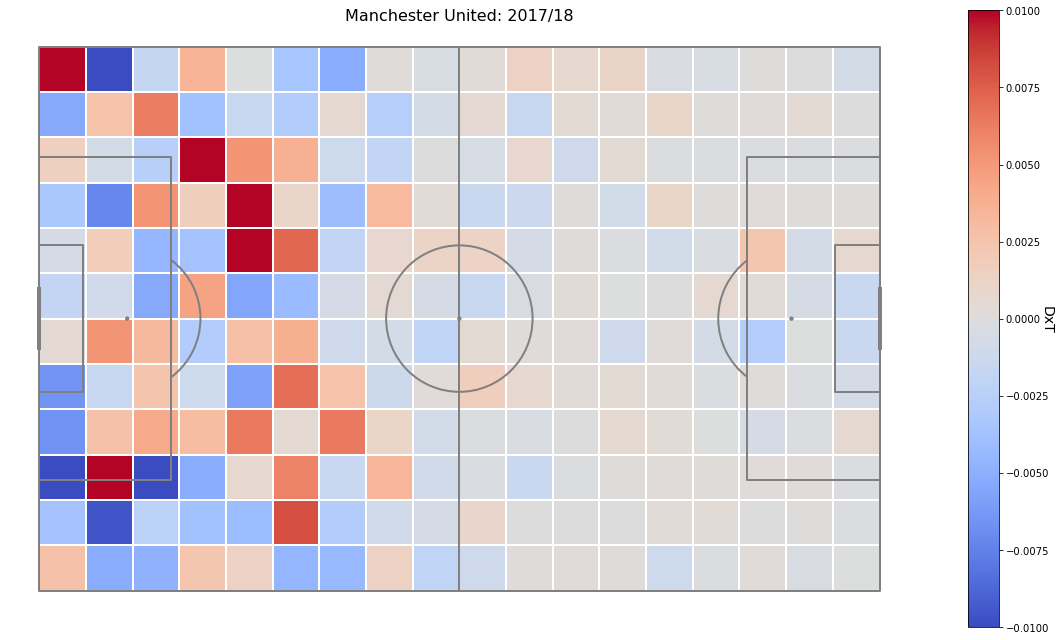

In [58]:
df_teams = deltaxT.produce_df_teams_ref(df_xT)

teamId = 1
teamName = df_teams.loc[df_teams['teamId'] == teamId, 'teamName'].values[0]
season = '2017/18'

df_season = df_xT.loc[df_xT['season'] == season].reset_index(drop=True).copy()

delta_xT_repo = '/Users/christian/Desktop/University/Birkbeck MSc Applied Statistics/Project/Plots/Team Delta xT'

deltaxT.plot_delta_xT_pitch(df_season, teamId, opta_events_relevant, os.path.join(delta_xT_repo, f'{teamName} {season}.png'.replace('/','-')), transparent=False, eventCol='eventSubType', bins=(18,12), exclCorners = 1, figsize=(16,9), fontsize=16, symmetricDeltaVizOverride=1)


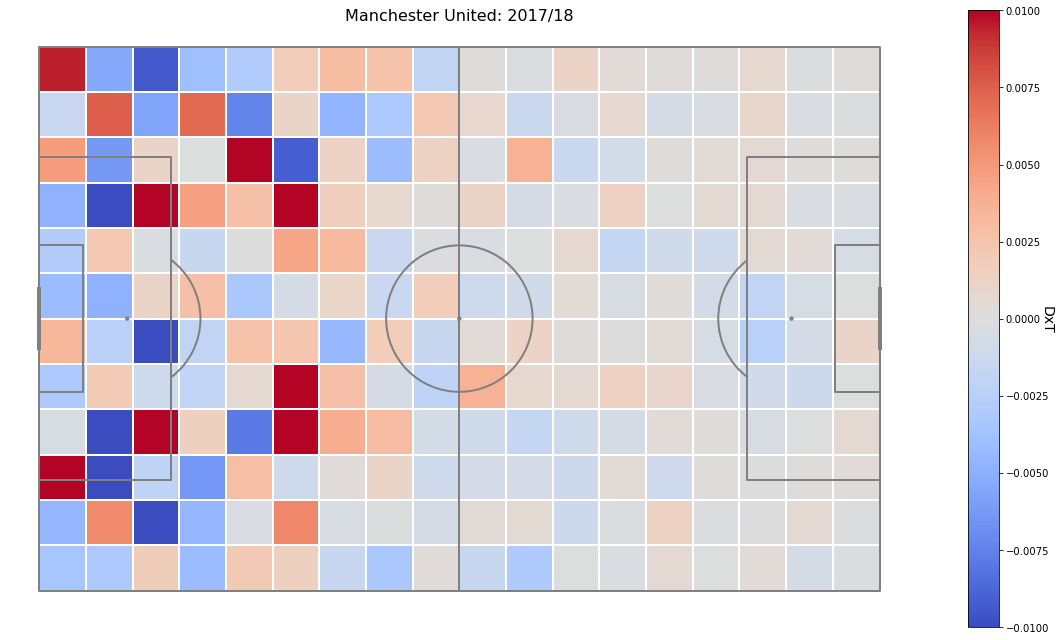

In [59]:
delta_xT_repo = '/Users/christian/Desktop/University/Birkbeck MSc Applied Statistics/Project/Plots/Team Delta xT'

deltaxT.plot_delta_xT_pitch(df_wyscout.loc[df_wyscout['source'] == 'England'], 1611, wyscout_events_relevant, os.path.join(delta_xT_repo, f'Wyscout_MUFC_1718.png'), transparent=False, eventCol='eventSubType', bins=(18,12), exclCorners = 1, figsize=(16,9), fontsize=16, symmetricDeltaVizOverride=1)


---

**Everything looking good!**

---

## **Producing Characterising Vectors of Team xT + Delta xT for both Wyscout & Opta, for All Domestic Teams + Seasons.**


In [60]:
# storing everything in these two dictionaries
dic_xT = {}
dic_delta_xT = {}

col_vendor = []
col_teamId = []
col_season = []
col_teamName = []

bins = (18,12)

### **Opta**

In [61]:
%%time

## opta
opta_seasons = ['2017/18','2018/19','2019/20','2020/21']

# reference dataframe for the Opta teams
df_opta_teams = deltaxT.produce_df_teams_ref(df_xT)

# getting list of Opta teamIds
lst_opta_teamId = df_opta_teams.teamId.values

# looping through the four seasons
for season in opta_seasons:
    
    # producing season dataframe
    df_season = df_xT.loc[df_xT['season'] == season].reset_index(drop=True).copy()
    
    # looping thruogh the teams
    for teamId in lst_opta_teamId:
    
        # producing team-season dataframes
        df_team_season = df_season.loc[df_season['playerTeamId'] == teamId].reset_index(drop=True).copy()
        
        # extracting team name
        teamName = df_opta_teams.loc[df_opta_teams['teamId'] == teamId, 'teamName'].values[0]
        
        if len(df_team_season) == 0:
            
            print (f'No data for {teamName} ({season})...')
            
        else:
        
            print (f'Processing {teamName} ({season})...')

            # populating team xT dic
            dic_xT[f'Opta - {teamName} - {season}'] = deltaxT.xT_grid(df_team_season, opta_events_relevant, bins=bins)
            col_vendor.append('Opta')
            col_teamId.append(teamId)
            col_teamName.append(teamName)
            col_season.append(season)
            
            # populating delta xT dic
            dic_delta_xT[f'Opta - {teamName} - {season}'] = deltaxT.delta_xT_grid(df_season, teamId, opta_events_relevant, bins=bins)
            
print ('Done.')

Processing Manchester United (2017/18)...
No data for Leeds United (2017/18)...
Processing Arsenal (2017/18)...
Processing Newcastle United (2017/18)...
Processing Tottenham Hotspur (2017/18)...
No data for Aston Villa (2017/18)...
Processing Chelsea (2017/18)...
Processing Everton (2017/18)...
Processing Leicester City (2017/18)...
Processing Liverpool (2017/18)...
Processing Southampton (2017/18)...
Processing West Ham United (2017/18)...
Processing Crystal Palace (2017/18)...
Processing West Bromwich Albion (2017/18)...
Processing Brighton and Hove Albion (2017/18)...
Processing Huddersfield Town (2017/18)...
No data for Wolverhampton Wanderers (2017/18)...
Processing Manchester City (2017/18)...
No data for Norwich City (2017/18)...
No data for Sheffield United (2017/18)...
No data for Fulham (2017/18)...
Processing Watford (2017/18)...
Processing Celtic (2017/18)...
Processing Swansea City (2017/18)...
Processing Burnley (2017/18)...
Processing Bournemouth (2017/18)...
No data for

### **Wyscout**

In [62]:
%%time

season = '2017/18'
regions = ['England','Italy','Spain','Germany','France']

# looping through the regions
for region in regions:
    
    # getting events dataframe for the region (the season bit is redundant as we only have one season, but adding it here to generalise)
    # will use this as input into delta xT grid
    df_region = df_wyscout.loc[(df_wyscout['source'] == region) & (df_wyscout['season'] == season)].reset_index(drop=True).copy()
    
    # getting list
    lst_wyscout_teamId = df_region.teamId.drop_duplicates().values
    
    # looping through the teams within that region (league)
    for teamId in lst_wyscout_teamId:
        
        # getting dataframe for the team & region (& season) -> use this for team xT grid
        df_team_region = df_region.loc[df_region['teamId'] == teamId].reset_index(drop=True).copy()
        
        # extracting team name
        teamName = df_wyscout_teams.loc[df_wyscout_teams['teamId'] == teamId, 'teamName'].values[0]

        print (f'Processing {region}: {teamName} ({season})...')

        # populating team xT dic
        dic_xT[f'Wyscout - {teamName} ({region}) - {season}'] = deltaxT.xT_grid(df_team_region, wyscout_events_relevant, bins=bins)
        col_vendor.append('Wyscout')
        col_teamId.append(teamId)
        col_teamName.append(teamName)
        col_season.append(season)

        # populating delta xT dic
        dic_delta_xT[f'Wyscout - {teamName} ({region}) - {season}'] = deltaxT.delta_xT_grid(df_region, teamId, wyscout_events_relevant, bins=bins)        
        
print ('Done.')

Processing England: Arsenal (2017/18)...
Processing England: Leicester City (2017/18)...
Processing England: Brighton & Hove Albion (2017/18)...
Processing England: Chelsea (2017/18)...
Processing England: Crystal Palace (2017/18)...
Processing England: Everton (2017/18)...
Processing England: Manchester United (2017/18)...
Processing England: Newcastle United (2017/18)...
Processing England: Southampton (2017/18)...
Processing England: Watford (2017/18)...
Processing England: West Bromwich Albion (2017/18)...
Processing England: AFC Bournemouth (2017/18)...
Processing England: Burnley (2017/18)...
Processing England: Huddersfield Town (2017/18)...
Processing England: Liverpool (2017/18)...
Processing England: Manchester City (2017/18)...
Processing England: Stoke City (2017/18)...
Processing England: Swansea City (2017/18)...
Processing England: Tottenham Hotspur (2017/18)...
Processing England: West Ham United (2017/18)...
Processing Italy: Roma (2017/18)...
Processing Italy: Atalant

---

## **Arranging Data Structures**

> Want to produce three data structures in two different formats.

**Three data structures:**
1. Team xT
2. Delta xT
3. Team xT + Delta xT

**Two formats:**
1. Numpy matrix format
2. TSV format for Google T-SNE viz

In [63]:
# note, these are identical for each dictionary
index_keys = np.array(list(dic_xT.keys()))

# getting the shape of the binned xT / delta xT data, as we'll want to straighten that out into row vectorss
grid_shape = dic_xT[index_keys[0]][0].shape
vector_length = grid_shape[0]*grid_shape[1]

print (f'We have {len(index_keys)} team-seasons (rows) of vectors of length {vector_length}')

# three formats
matrix_team_xT = np.zeros((len(index_keys),vector_length))
matrix_delta_xT = np.zeros((len(index_keys),vector_length))
matrix_combined_xT = np.zeros((len(index_keys),vector_length*2))

# populating matrices
## 1) team_xT
for n, key in enumerate(index_keys):
    matrix_team_xT[n,:] = dic_xT[key][0].reshape(vector_length)

## 2) delta_xT
for n, key in enumerate(index_keys):
    matrix_delta_xT[n,:] = dic_delta_xT[key][1].reshape(vector_length)

## 3) combined_xT
matrix_combined_xT[:,0:vector_length] = matrix_team_xT
matrix_combined_xT[:,vector_length:] = matrix_delta_xT

### standardising matrices
matrix_team_xT = StandardScaler().fit_transform(matrix_team_xT)
matrix_delta_xT = StandardScaler().fit_transform(matrix_delta_xT)
matrix_combined_xT = StandardScaler().fit_transform(matrix_combined_xT)

We have 233 team-seasons (rows) of vectors of length 216


### **Outputting to pickle**

In [75]:
repo_vectors = r'/Users/christian/Desktop/University/Birkbeck MSc Applied Statistics/Project/Data/Analysis Ready/xT Vectors'

### **Outputting and loading from pickle**

#### Index Keys: All

In [76]:
#with open(os.path.join(repo_vectors, 'index_keys_all.pkl'), 'wb') as f:
    #pickle.dump(index_keys, f)

with open(os.path.join(repo_vectors, 'index_keys_all.pkl'), 'rb') as f:
    index_keys = pickle.load(f)
    
len(index_keys)

178

#### Index Keys: Just Opta

In [134]:
#with open(os.path.join(repo_vectors, 'index_keys_opta.pkl'), 'wb') as f:
    #pickle.dump(index_keys, f)

with open(os.path.join(repo_vectors, 'index_keys_opta.pkl'), 'rb') as f:
    index_keys = pickle.load(f)
    
len(index_keys)

80

#### Column Labels

In [77]:
# pickling col vectors
#with open(os.path.join(repo_vectors, 'col_vendor.pkl'), 'wb') as f:
    #pickle.dump(col_vendor, f)
    
#with open(os.path.join(repo_vectors, 'col_teamId.pkl'), 'wb') as f:
    #pickle.dump(col_teamId, f)
    
#with open(os.path.join(repo_vectors, 'col_season.pkl'), 'wb') as f:
    #pickle.dump(col_season, f)
    
#with open(os.path.join(repo_vectors, 'col_teamName.pkl'), 'wb') as f:
    #pickle.dump(col_teamName, f)

##########################################################################################
    
# reading pickled col vectors
with open(os.path.join(repo_vectors, 'col_vendor.pkl'), 'rb') as f:
    col_vendor = pickle.load(f)
    
with open(os.path.join(repo_vectors, 'col_teamId.pkl'), 'rb') as f:
    col_teamId = pickle.load(f)
    
with open(os.path.join(repo_vectors, 'col_season.pkl'), 'rb') as f:
    col_season = pickle.load(f)
    
with open(os.path.join(repo_vectors, 'col_teamName.pkl'), 'rb') as f:
    col_teamName = pickle.load(f)

# filtering whether All / Just Opta
col_vendor = col_vendor[:len(index_keys)]
col_teamId = col_teamId[:len(index_keys)]
col_season = col_season[:len(index_keys)]
col_teamName = col_teamName[:len(index_keys)]

len(col_vendor), len(col_teamId), len(col_season), len(col_teamName)

(178, 178, 178, 178)

#### High Res Pickle: All

In [78]:
# pickling matrices
#with open(os.path.join(repo_vectors, 'matrix_team_xT_all.pkl'), 'wb') as f:
    #pickle.dump(matrix_team_xT, f)
    
#with open(os.path.join(repo_vectors, 'matrix_delta_xT_all.pkl'), 'wb') as f:
    #pickle.dump(matrix_delta_xT, f)
    
#with open(os.path.join(repo_vectors, 'matrix_combined_xT_all.pkl'), 'wb') as f:
    #pickle.dump(matrix_combined_xT, f)

##########################################################################################
    
# reading pickled matrices
with open(os.path.join(repo_vectors, 'matrix_team_xT_all.pkl'), 'rb') as f:
    matrix_team_xT = pickle.load(f)
    
with open(os.path.join(repo_vectors, 'matrix_delta_xT_all.pkl'), 'rb') as f:
    matrix_delta_xT = pickle.load(f)
    
with open(os.path.join(repo_vectors, 'matrix_combined_xT_all.pkl'), 'rb') as f:
    matrix_combined_xT = pickle.load(f)
    

#### High Res Pickle: Just Opta

In [137]:
# pickling matrices
#with open(os.path.join(repo_vectors, 'matrix_team_xT_opta.pkl'), 'wb') as f:
    #pickle.dump(matrix_team_xT, f)
    
#with open(os.path.join(repo_vectors, 'matrix_delta_xT_opta.pkl'), 'wb') as f:
    #pickle.dump(matrix_delta_xT, f)
    
#with open(os.path.join(repo_vectors, 'matrix_combined_xT_opta.pkl'), 'wb') as f:
    #pickle.dump(matrix_combined_xT, f)

##########################################################################################
    
# reading pickled matrices
with open(os.path.join(repo_vectors, 'matrix_team_xT_opta.pkl'), 'rb') as f:
    matrix_team_xT = pickle.load(f)
    
with open(os.path.join(repo_vectors, 'matrix_delta_xT_opta.pkl'), 'rb') as f:
    matrix_delta_xT = pickle.load(f)
    
with open(os.path.join(repo_vectors, 'matrix_combined_xT_opta.pkl'), 'rb') as f:
    matrix_combined_xT = pickle.load(f)
    

#### Low Res Pickle: All

In [52]:
# pickling matrices
#with open(os.path.join(repo_vectors, 'matrix_team_xT_low_res_all.pkl'), 'wb') as f:
    #pickle.dump(matrix_team_xT, f)
    
#with open(os.path.join(repo_vectors, 'matrix_delta_xT_low_res_all.pkl'), 'wb') as f:
    #pickle.dump(matrix_delta_xT, f)
    
#with open(os.path.join(repo_vectors, 'matrix_combined_xT_low_res_all.pkl'), 'wb') as f:
    #pickle.dump(matrix_combined_xT, f)

##########################################################################################

# reading pickled matrices
with open(os.path.join(repo_vectors, 'matrix_team_xT_low_res_all.pkl'), 'rb') as f:
    matrix_team_xT = pickle.load(f)
    
with open(os.path.join(repo_vectors, 'matrix_delta_xT_low_res_all.pkl'), 'rb') as f:
    matrix_delta_xT = pickle.load(f)
    
with open(os.path.join(repo_vectors, 'matrix_combined_xT_low_res_all.pkl'), 'rb') as f:
    matrix_combined_xT = pickle.load(f)

#### Low Res Pickle: Just Opta

In [148]:
# pickling matrices
#with open(os.path.join(repo_vectors, 'matrix_team_xT_low_res_opta.pkl'), 'wb') as f:
    #pickle.dump(matrix_team_xT, f)
    
#with open(os.path.join(repo_vectors, 'matrix_delta_xT_low_res_opta.pkl'), 'wb') as f:
    #pickle.dump(matrix_delta_xT, f)
    
#with open(os.path.join(repo_vectors, 'matrix_combined_xT_low_res_opta.pkl'), 'wb') as f:
    #pickle.dump(matrix_combined_xT, f)

##########################################################################################

# reading pickled matrices
with open(os.path.join(repo_vectors, 'matrix_team_xT_low_res_opta.pkl'), 'rb') as f:
    matrix_team_xT = pickle.load(f)
    
with open(os.path.join(repo_vectors, 'matrix_delta_xT_low_res_opta.pkl'), 'rb') as f:
    matrix_delta_xT = pickle.load(f)
    
with open(os.path.join(repo_vectors, 'matrix_combined_xT_low_res_opta.pkl'), 'rb') as f:
    matrix_combined_xT = pickle.load(f)

### **Outputting to TSV**

In [53]:
# outputting labels
pd.DataFrame(index_keys, columns=['indexKey']).to_csv(os.path.join(repo_vectors, 'labels.csv'), index=None, header=None)

# outputting the three matrices
np.savetxt(os.path.join(repo_vectors, 'matrix_team_xT.csv'), matrix_team_xT, delimiter="\t")
np.savetxt(os.path.join(repo_vectors, 'matrix_delta_xT.csv'), matrix_delta_xT, delimiter="\t")
np.savetxt(os.path.join(repo_vectors, 'matrix_combined_xT.csv'), matrix_combined_xT, delimiter="\t")


#### Checking the shapes of the matrices

> Should be team-seasons X xT vector lengths

In [79]:
matrix_team_xT.shape

(178, 216)

In [80]:
matrix_delta_xT.shape

(178, 216)

In [81]:
matrix_combined_xT.shape

(178, 432)

## **Dimensionality Reduction**

In [82]:
%%time

# PCA
numDimensions = 2

# fitting PCA
pca = PCA(n_components = numDimensions)
matrix_pca_team = pca.fit_transform(matrix_team_xT)

pca = PCA(n_components = numDimensions)
matrix_pca_delta = pca.fit_transform(matrix_delta_xT)

pca = PCA(n_components = numDimensions)
matrix_pca_combined = pca.fit_transform(matrix_combined_xT)

pca.explained_variance_ratio_
sum(pca.explained_variance_ratio_)

CPU times: user 721 ms, sys: 63.6 ms, total: 784 ms
Wall time: 147 ms


0.1794827859122918

In [83]:
# Mapping meta to PCA co-ords
df_pca_team = pd.DataFrame(matrix_pca_team, columns=[f'dim_{i}' for i in np.arange(0, numDimensions)])
df_pca_team['label'] = index_keys
df_pca_team['teamId'] = col_teamId
df_pca_team['teamName'] = col_teamName
df_pca_team['season'] = col_season
df_pca_team['vendor'] = col_vendor

df_pca_delta = pd.DataFrame(matrix_pca_delta, columns=[f'dim_{i}' for i in np.arange(0, numDimensions)])
df_pca_delta['label'] = index_keys
df_pca_delta['teamId'] = col_teamId
df_pca_delta['teamName'] = col_teamName
df_pca_delta['season'] = col_season
df_pca_delta['vendor'] = col_vendor

df_pca_combined = pd.DataFrame(matrix_pca_combined, columns=[f'dim_{i}' for i in np.arange(0, numDimensions)])
df_pca_combined['label'] = index_keys
df_pca_combined['teamId'] = col_teamId
df_pca_combined['teamName'] = col_teamName
df_pca_combined['season'] = col_season
df_pca_combined['vendor'] = col_vendor

## **K-means clustering**

In [ ]:
# initialising k-means
numClusters = 28
#numClusters = 16

# using Kmeans on PCA matrices
## 1) team PCA
km = KMeans(n_clusters = numClusters, init='random', n_init=20, max_iter=3000, tol=1e-5, random_state=0)
pca_team_clusterer = km.fit(matrix_pca_team)

## 2) delta PCA
km = KMeans(n_clusters = numClusters, init='random', n_init=20, max_iter=3000, tol=1e-5, random_state=0)
pca_delta_clusterer = km.fit(matrix_pca_delta)

## 3) combined PCA
km = KMeans(n_clusters = numClusters, init='random', n_init=20, max_iter=3000, tol=1e-5, random_state=0)
pca_combined_clusterer = km.fit(matrix_pca_combined)

# applying K-means cluster labels to PCA dataframe
df_pca_team['clusterId'] = pca_team_clusterer.labels_
df_pca_delta['clusterId'] = pca_delta_clusterer.labels_
df_pca_combined['clusterId'] = pca_combined_clusterer.labels_

# colour labels per cluster, using colourblind colour palette from seaborn
palette = seaborn.color_palette('colorblind', numClusters).as_hex()

# team
team_colours = [palette[x] if x >= 0 else '#000000' for x in df_pca_team.clusterId]
df_pca_team['colour'] = team_colours

# delta
delta_colours = [palette[x] if x >= 0 else '#000000' for x in df_pca_delta.clusterId]
df_pca_delta['colour'] = delta_colours

# combined
combined_colours = [palette[x] if x >= 0 else '#000000' for x in df_pca_combined.clusterId]
df_pca_combined['colour'] = combined_colours

# viewing the team cluster
df_pca_combined.sort_values(['clusterId','teamName']).head(25)

## **Plotting**

In [ ]:
# Loading BokehJS...
output_notebook()

### 1) Plotting Team xT Clusters

In [89]:
# plot Team xT clusters interactively using Bokeh
plot_data = ColumnDataSource(df_pca_team)

# create the plot and configure the title, dimensions, and tools
pca_plot = figure(title = '2D Projection Team xT Clusters',
                   plot_width = 1400,
                   plot_height = 800,
                   tools= ( 'pan, wheel_zoom,'
                            'lasso_select, reset'),
                   active_scroll = 'wheel_zoom')

# show vendor-team-season labels
pca_plot.add_tools( HoverTool(tooltips = u'@label') )

# draw teams as circles
pca_plot.circle('dim_0', 'dim_1', source = plot_data,
                 color = u'colour', line_alpha = 0.2, fill_alpha = 0.6,
                 size = 25, hover_line_color = 'black')

# configure visual elements of the plot
pca_plot.xaxis.visible = False
pca_plot.yaxis.visible = False
pca_plot.grid.grid_line_color = None
pca_plot.outline_line_color = None

# plot!
show(pca_plot)

# save the results to a file
#save(pca_plot, filename='/Users/christian/Desktop/University/Birkbeck MSc Applied Statistics/Project/Plots/Clustering/Team_xT_Clusters.html')

### 2) Plotting Delta xT Clusters

In [87]:
# plot Delta xT clusters interactively using Bokeh
plot_data = ColumnDataSource(df_pca_delta)

# create the plot and configure the title, dimensions, and tools
pca_plot = figure(title = '2D Projection Delta xT Clusters',
                   plot_width = 1400,
                   plot_height = 800,
                   tools= ( 'pan, wheel_zoom,'
                            'lasso_select, reset'),
                   active_scroll = 'wheel_zoom')

# show vendor-team-season labels
pca_plot.add_tools( HoverTool(tooltips = u'@label') )

# draw teams as circles
pca_plot.circle('dim_0', 'dim_1', source = plot_data,
                 color = u'colour', line_alpha = 0.2, fill_alpha = 0.6,
                 size = 25, hover_line_color = 'black')

# configure visual elements of the plot
pca_plot.xaxis.visible = False
pca_plot.yaxis.visible = False
pca_plot.grid.grid_line_color = None
pca_plot.outline_line_color = None

# plot!
show(pca_plot);

# save the results to a file
#save(pca_plot, filename='/Users/christian/Desktop/University/Birkbeck MSc Applied Statistics/Project/Plots/Clustering/Delta_xT_Clusters.html')

### 3) Plotting Combined Clusters

In [90]:
# plot combined xT clusters interactively using Bokeh
plot_data = ColumnDataSource(df_pca_combined)

# create the plot and configure the title, dimensions, and tools
pca_plot = figure(title = '2D Projection Combined xT Clusters',
                   plot_width = 1400,
                   plot_height = 800,
                   tools= ( 'pan, wheel_zoom,'
                            'lasso_select, reset'),
                   active_scroll = 'wheel_zoom')

# show vendor-team-season labels
pca_plot.add_tools( HoverTool(tooltips = u'@label') )

# draw teams as circles
pca_plot.circle('dim_0', 'dim_1', source = plot_data,
                 color = u'colour', line_alpha = 0.2, fill_alpha = 0.6,
                 size = 25, hover_line_color = 'black')

# configure visual elements of the plot
pca_plot.xaxis.visible = False
pca_plot.yaxis.visible = False
pca_plot.grid.grid_line_color = None
pca_plot.outline_line_color = None

# plot!
show(pca_plot)

# save the results to a file
#save(pca_plot, filename='/Users/christian/Desktop/University/Birkbeck MSc Applied Statistics/Project/Plots/Clustering/Combined_xT_Clusters.html')

In [32]:
import chromedriver_binary
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
driver = webdriver.Chrome(ChromeDriverManager(version='91.0.4472.19').install())

export_png(pca_plot, filename='/Users/christian/Desktop/University/Birkbeck MSc Applied Statistics/Project/Plots/Clustering/Combined_xT_Clusters.png', webdriver=driver)



====== WebDriver manager ======
Current google-chrome version is 91.0.4472
Driver [/Users/christian/.wdm/drivers/chromedriver/mac64/91.0.4472.19/chromedriver] found in cache


'/Users/christian/Desktop/University/Birkbeck MSc Applied Statistics/Project/Plots/Clustering/Combined_xT_Clusters.png'